In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('C:\\Users\\Suraj\\OneDrive\\Desktop\\Cryptocurrency Volatility Prediction ML Project\\data\\dataset.csv')
df

,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.000000e+00,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.000000e+00,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.000000e+00,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.000000e+00,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.000000e+00,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07
...,...,...,...,...,...,...,...,...,...,...
72941,72941,0.022604,0.022988,0.022197,0.022796,4.040134e+07,1.652957e+09,2022-10-23T23:59:59.999Z,VeChain,2022-10-23
72942,72942,1.468244,1.530464,1.435415,1.517878,2.844351e+07,1.572825e+09,2022-10-23T23:59:59.999Z,Flow,2022-10-23
72943,72943,4.950431,5.148565,4.945280,5.117206,1.069497e+08,1.559551e+09,2022-10-23T23:59:59.999Z,Filecoin,2022-10-23
72944,72944,0.000233,0.000243,0.000226,0.000239,2.143268e+08,1.576291e+09,2022-10-23T23:59:59.999Z,Terra Classic,2022-10-23


In [3]:
df.columns

Index(['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'marketCap',
       'timestamp', 'crypto_name', 'date'],
      dtype='object')

In [4]:
df.columns = df.columns.str.lower() 
df = df.rename(columns={'marketcap': 'market_cap'}) 
df['date'] = pd.to_datetime(df['date'])

In [5]:
df = df.drop(columns=['unnamed: 0'], errors='ignore') 
df = df.sort_values(['crypto_name', 'date']).drop_duplicates(['crypto_name', 'date']) 
df[['open','high','low','close','volume','market_cap']] = df[['open','high','low','close','volume','market_cap']].apply(pd.to_numeric, errors='coerce') 
df[['volume','market_cap']] = df[['volume','market_cap']].clip(lower=0)

In [6]:
print("Dataset shape:", df.shape) 
print("crypto_name:", df['crypto_name'].unique()) 
print("Date range:", df['date'].min(), "to", df['date'].max())

Dataset shape: (72946, 9)
crypto_name: ['Aave' 'Algorand' 'ApeCoin' 'Aptos' 'Avalanche' 'BNB'
 'Basic Attention Token' 'Binance USD' 'Bitcoin' 'Bitcoin Cash' 'Cardano'
 'Casper' 'Chain' 'Chainlink' 'Chiliz' 'Cosmos' 'Cronos' 'Dai'
 'Decentraland' 'Dogecoin' 'EOS' 'Elrond' 'Ethereum' 'Ethereum Classic'
 'FTX Token' 'Filecoin' 'Flow' 'Hedera' 'Huobi Token' 'Internet Computer'
 'Litecoin' 'Maker' 'Monero' 'NEAR Protocol' 'OKB' 'Polkadot' 'Polygon'
 'Quant' 'Ravencoin' 'Shiba Inu' 'Solana' 'Stellar' 'THORChain' 'TRON'
 'Terra Classic' 'Tether' 'Tezos' 'The Sandbox' 'Theta Network' 'Toncoin'
 'UNUS SED LEO' 'USD Coin' 'Uniswap' 'VeChain' 'Wrapped Bitcoin' 'XRP']
Date range: 2013-05-05 00:00:00 to 2022-10-23 00:00:00


In [7]:
missing = df.isnull().sum() 
print("Missing values:\n", missing)

Missing values:
 open           0
high           0
low            0
close          0
volume         0
market_cap     0
timestamp      0
crypto_name    0
date           0
dtype: int64


In [8]:
df['date']

44644   2020-10-02
44709   2020-10-03
44780   2020-10-04
44826   2020-10-05
44843   2020-10-06
           ...    
72716   2022-09-25
72768   2022-10-02
72806   2022-10-09
72859   2022-10-16
72945   2022-10-23
Name: date, Length: 72946, dtype: datetime64[ns]

# Feature Engineering

In [9]:
df['log_ret'] = np.log(df['close'] / df['close'].shift(1)) 
df['vol_7d'] = df['log_ret'].rolling(7).std() 
df['vol_14d'] = df['log_ret'].rolling(14).std()

In [10]:
# Garman–Klass Volatility 

gk_raw = (
    0.5 * (np.log(df['high'] / df['low']) ** 2) -
    2 * (np.log(df['close'] / df['open']) ** 2)
)

# Replace negative values with NaN before sqrt
gk_raw[gk_raw < 0] = np.nan

df['garman_klass'] = np.sqrt(gk_raw)

In [11]:
# Liquidity Ratios 

df['hl_spread'] = (df['high'] - df['low']) / df['close']
df['turnover'] = df['volume'] / df['market_cap']

In [12]:
# Calendar Features 

df['day_of_week'] = df['date'].dt.dayofweek 
df['month'] = df['date'].dt.month

In [13]:
# Target Variable 

df['target_vol'] = df['garman_klass'].shift(-1)

In [14]:
# Drop NA and Save 

df = df.dropna() 
df.to_parquet('../data/processed/features.parquet')

In [15]:
cleaned_df = pd.read_parquet('C:\\Users\\Suraj\\OneDrive\\Desktop\\Cryptocurrency Volatility Prediction ML Project\\data\\processed\\features.parquet')
cleaned_df.head(5)

,open,high,low,close,volume,market_cap,timestamp,crypto_name,date,log_ret,vol_7d,vol_14d,garman_klass,hl_spread,turnover,day_of_week,month,target_vol
45398,39.486192,43.077373,38.633613,41.366993,4.333969e+07,3.823670e+08,2020-10-17T23:59:59.999Z,Aave,2020-10-17,0.046288,0.077838,0.090158,0.039955,0.107423,0.113346,5,10,0.031625
45785,39.455022,40.928509,37.601201,37.904761,4.397045e+07,4.048626e+08,2020-10-25T23:59:59.999Z,Aave,2020-10-25,-0.040085,0.095072,0.083418,0.019524,0.087781,0.108606,6,10,0.031062
45815,37.904763,39.163864,35.071968,36.033922,5.030722e+07,3.848801e+08,2020-10-26T23:59:59.999Z,Aave,2020-10-26,-0.050616,0.083948,0.081252,0.031062,0.113557,0.130709,0,10,0.071165
46058,31.217823,32.900161,29.610259,29.707518,5.863107e+07,3.335160e+08,2020-10-31T23:59:59.999Z,Aave,2020-10-31,-0.049589,0.054904,0.076137,0.025137,0.110743,0.175797,5,10,0.041893
46121,29.707518,31.067060,28.494482,30.657276,4.956834e+07,3.454655e+08,2020-11-01T23:59:59.999Z,Aave,2020-11-01,0.031470,0.061291,0.077544,0.041893,0.083914,0.143483,6,11,0.092910


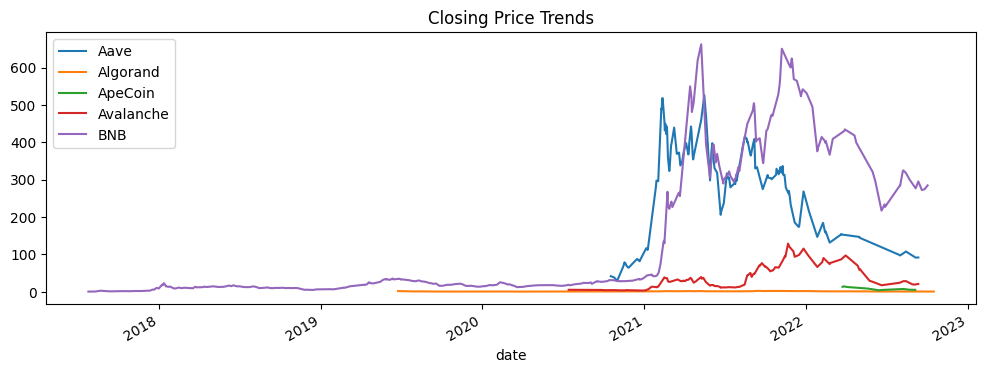

In [16]:
# Price Trends 

for name in df['crypto_name'].unique()[:5]: 
    df[df['crypto_name'] == name].set_index('date')['close'].plot(label=name, figsize=(12,4)) 
plt.title("Closing Price Trends") 
plt.legend() 
plt.show()

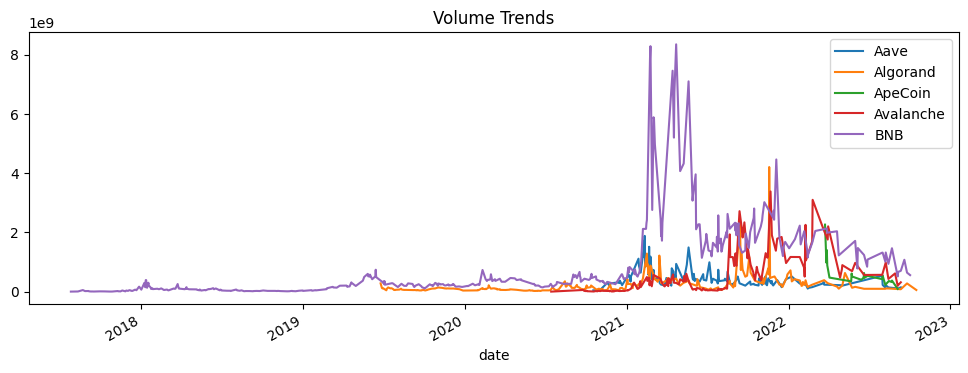

In [17]:
# Volume Trends 
for name in df['crypto_name'].unique()[:5]: 
    df[df['crypto_name'] == name].set_index('date')['volume'].plot(label=name, figsize=(12,4)) 
plt.title("Volume Trends") 
plt.legend() 
plt.show()

In [18]:
# Define large caps as top 10% by average market_cap 

cap_threshold = df.groupby("crypto_name")["market_cap"].mean().quantile(0.9) 
large_caps = df.groupby("crypto_name")["market_cap"].mean() 
large_cap_names = large_caps[large_caps >= cap_threshold].index

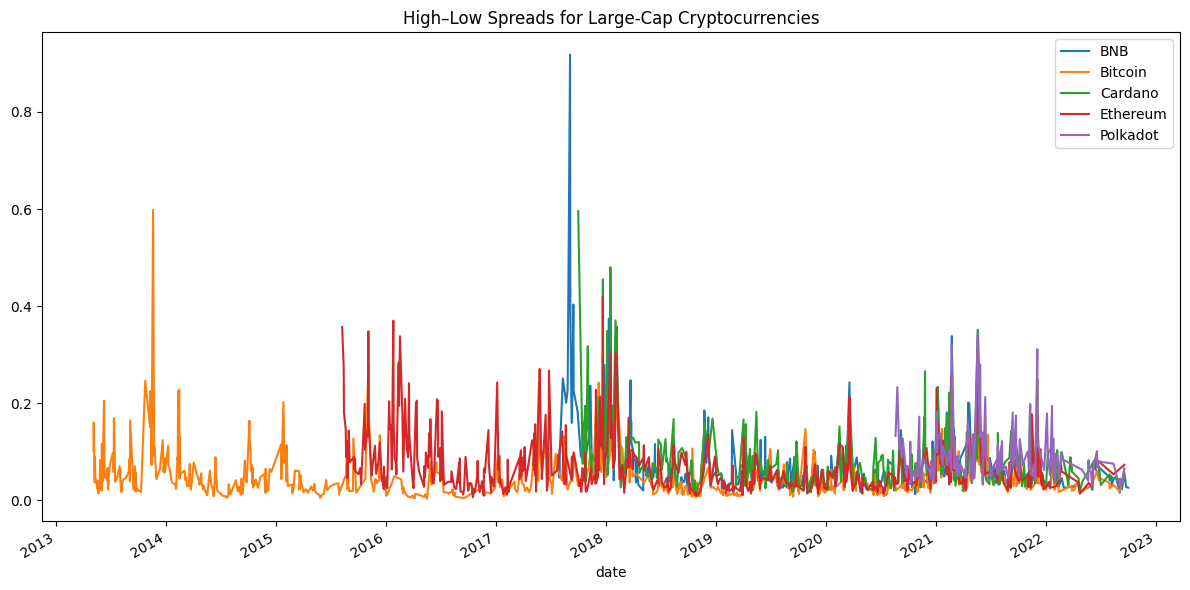

In [19]:
plt.figure(figsize=(12,6)) 
for name in large_cap_names[:5]: 
    df[df["crypto_name"] == name].set_index("date")["hl_spread"].plot(label=name) 
plt.title("High–Low Spreads for Large-Cap Cryptocurrencies") 
plt.legend() 
plt.tight_layout() 
plt.show()

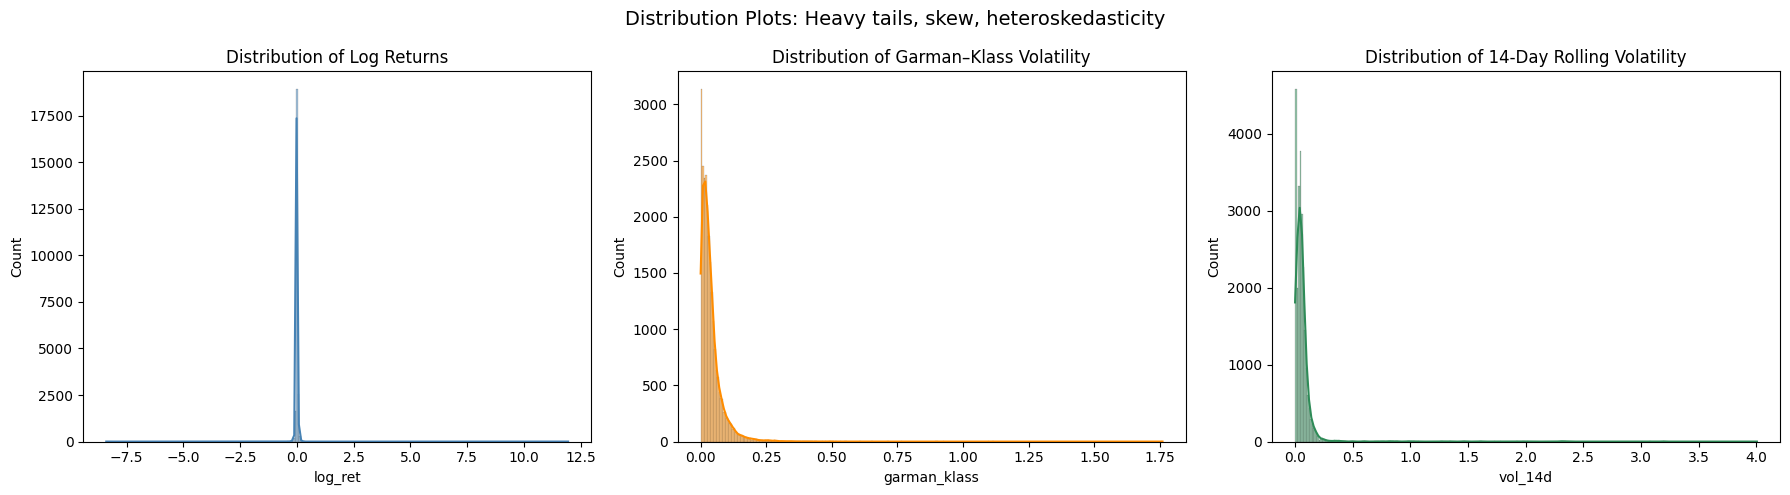

In [20]:
# Distribution plots 
 
fig, axes = plt.subplots(1, 3, figsize=(18,5)) 
sns.histplot(df["log_ret"], kde=True, ax=axes[0], color="steelblue") 
axes[0].set_title("Distribution of Log Returns") 
sns.histplot(df["garman_klass"], kde=True, ax=axes[1], color="darkorange") 
axes[1].set_title("Distribution of Garman–Klass Volatility") 
sns.histplot(df["vol_14d"], kde=True, ax=axes[2], color="seagreen") 
axes[2].set_title("Distribution of 14-Day Rolling Volatility") 
plt.suptitle("Distribution Plots: Heavy tails, skew, heteroskedasticity", fontsize=14) 
plt.tight_layout() 
plt.show()

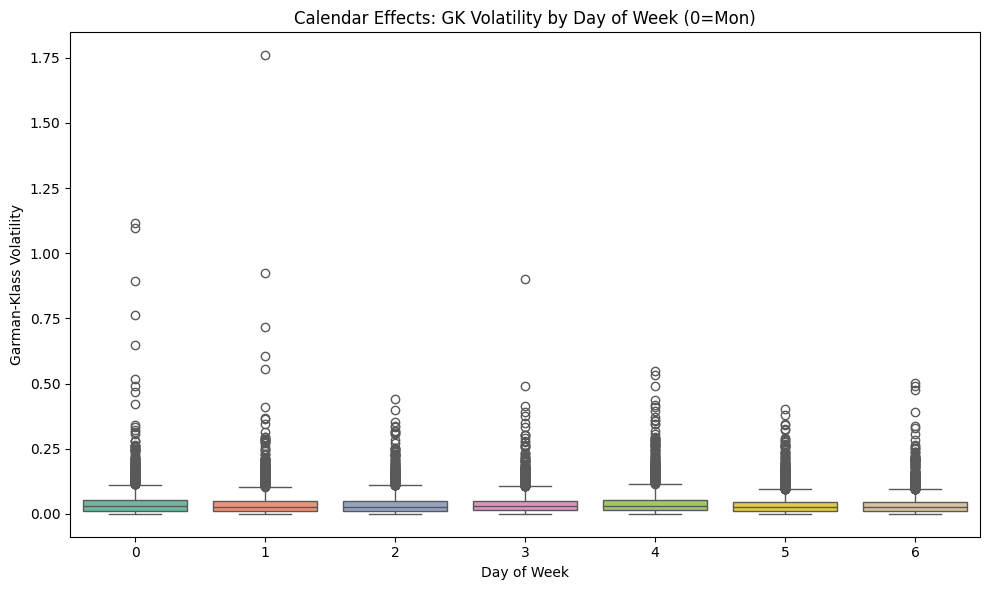

In [21]:
# Calendar effects 

plt.figure(figsize=(10,6))
sns.boxplot(x="day_of_week", y="garman_klass", data=df, hue="day_of_week", palette="Set2", legend=False)
plt.title("Calendar Effects: GK Volatility by Day of Week (0=Mon)")
plt.xlabel("Day of Week")
plt.ylabel("Garman-Klass Volatility")
plt.tight_layout()
plt.show()

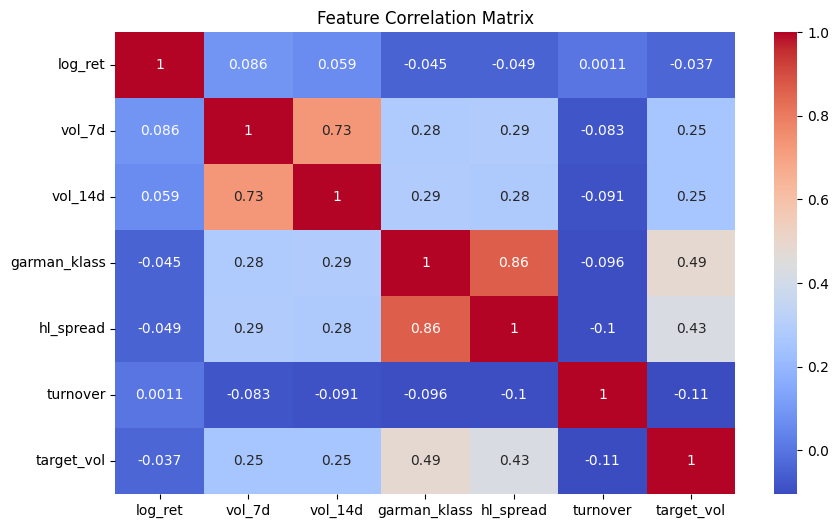

In [22]:
# Correlation Matrix 
 
plt.figure(figsize=(10,6)) 
sns.heatmap(df[['log_ret','vol_7d','vol_14d','garman_klass','hl_spread','turnover','target_vol']].corr(), annot=True, cmap='coolwarm') 
plt.title("Feature Correlation Matrix") 
plt.show()